# Protected Probabilistic Classification for Multiclass problems

This notebook gives an implementation example of Protected classification for multiclass classification problems. 

Protected classification is decribed in more detail in:

 - Vovk, Vladimir, Ivan Petej, and Alex Gammerman. "Protected probabilistic classification." In Conformal and Probabilistic Prediction and Applications, pp. 297-299. PMLR, 2021. (arxiv version https://arxiv.org/pdf/2107.01726.pdf)

The Protected Classificaton algorithm can be applied in two ways:

- **batch mode** where we fit it to the training set only and when applied to the test set, the algorithm yields calibrated probability outputs in a similar way to Platt, Isotonic or Venn-Abers calibration
     
- **online mode**, where we assume examples in the test set arrive sequentially and the algorithm protects aagains changes in the underlying data distribution (withiut having to retrain the underlying algorithm)

In this example we focus on the latter (**online mode**) application.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import sys


from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn import metrics

from sklearn.metrics import (
    accuracy_score,
    log_loss)

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from protected_classification import (ProtectedClassification, cox_multiclass, gen_alpha, 
                                            generate_protected_params, y_encode)

import warnings
warnings.filterwarnings('ignore')

## Create synthetic dataset

We create a synthetic dataset with 3 classes only for ease of illustration

In [2]:
random_seed = 2025
np.random.seed(seed=random_seed)

n_classes = 3
betas = [1, 0.5, 2]

X, y = make_classification(
    n_samples=10000, n_classes=n_classes, n_informative=10, random_state=random_seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_seed)

Parameters **alpha** are set to zero for each class and to +-1 for each class respectively 

In [3]:
protected_params = generate_protected_params(betas, n_classes)
alphas = protected_params[0]
alphas

[[0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [-1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, -1.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, -1.0]]

This is effecively the same Ccox calibration set as in the binary case for each one-vs-one class combination. We consider here an example of calibrating between 0 and 1 class

In [4]:
alphas_0_1 = [alp[:2] for alp in alphas if alp[2] ==0]

In [5]:
calibs = [[cox_multiclass([1-i, i], alp, bet) for i in np.linspace(0,1,101)] for alp in alphas_0_1 for bet in betas]
calib_label = [[str(alp), str(bet)] for alp in alphas for bet in betas]

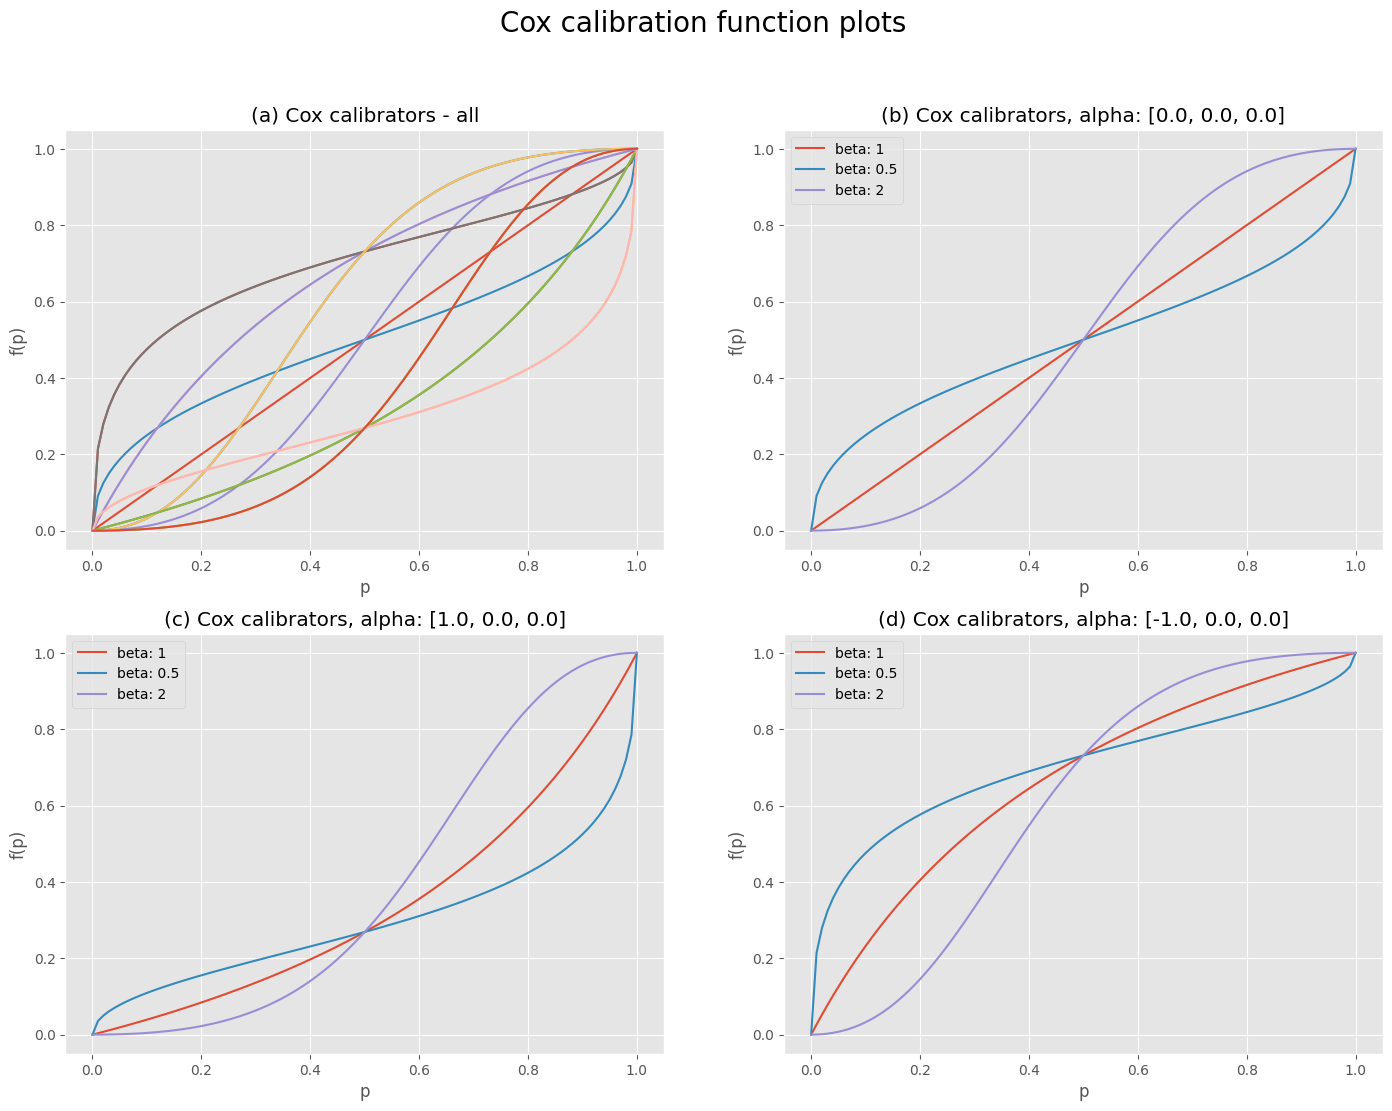

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(17,12))

for ind, calib in enumerate(calibs):
        ax[0,0].plot(np.linspace(0,1,101), np.array(calib)[:,1], '-', label = 'alpha: ' + calib_label[ind][0] + ' beta: ' + calib_label[ind][1])
ax[0,0].set_xlabel('p')
ax[0,0].set_ylabel('f(p)')
ax[0,0].set_title('(a) Cox calibrators - all')

for ind, calib in enumerate(calibs[:3]):
        ax[0,1].plot(np.linspace(0,1,101), np.array(calib)[:,1], '-',  label = 'beta: ' + calib_label[ind][1])
ax[0,1].set_xlabel('p')
ax[0,1].set_ylabel('f(p)')
ax[0,1].set_title('(b) Cox calibrators, alpha: ' + calib_label[ind][0])
ax[0,1].legend()

for ind, calib in enumerate(calibs[3:6]):
        ax[1,0].plot(np.linspace(0,1,101), np.array(calib)[:,1], '-', label = 'beta: ' + calib_label[ind+3][1])
ax[1,0].set_xlabel('p')
ax[1,0].set_ylabel('f(p)')
ax[1,0].set_title('(c) Cox calibrators, alpha: ' + calib_label[ind+3][0])
ax[1,0].legend()

for ind, calib in enumerate(calibs[6:9]):
        ax[1,1].plot(np.linspace(0,1,101), np.array(calib)[:,1], '-', label = 'beta: ' + calib_label[ind+6][1])
ax[1,1].set_xlabel('p')
ax[1,1].set_ylabel('f(p)')
ax[1,1].legend()
ax[1,1].set_title('(d) Cox calibrators, alpha: ' + calib_label[ind+6][0])

plt.suptitle("Cox calibration function plots", fontsize=20)
plt.show()

## Multi-class calibration

We use a RF classifier and assume that the test set experiences a dataset shift, where the 0 and 1 labels are permuted for the last 1000 examples

In [7]:
clf = RandomForestClassifier(random_state=random_seed, n_estimators = 1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
p_pred = clf.predict_proba(X_test)

In [8]:
y_test_shift = y_test
y_test_shift[-1000:][y_test[-1000:]==0] = 1
y_test_shift[-1000:][y_test[-1000:]==1] = 0

We apply the protected classification algorithm. Please note that the y-labels should ba a single array of unique labels rather than the one-hot-encoded equivalent

In [9]:
pc = ProtectedClassification(estimator=clf)
p_prime, stats = pc.predict_proba(X_test, y_test_shift, return_stats=True)
y_prime = pc.predict(X_test, y_test_shift)

We compare the cumulative log loss of the random forest (base) and protected classifiers on the test set and the corresponding composite jumper martingale (the start of the dataset shift can be clearly seen)

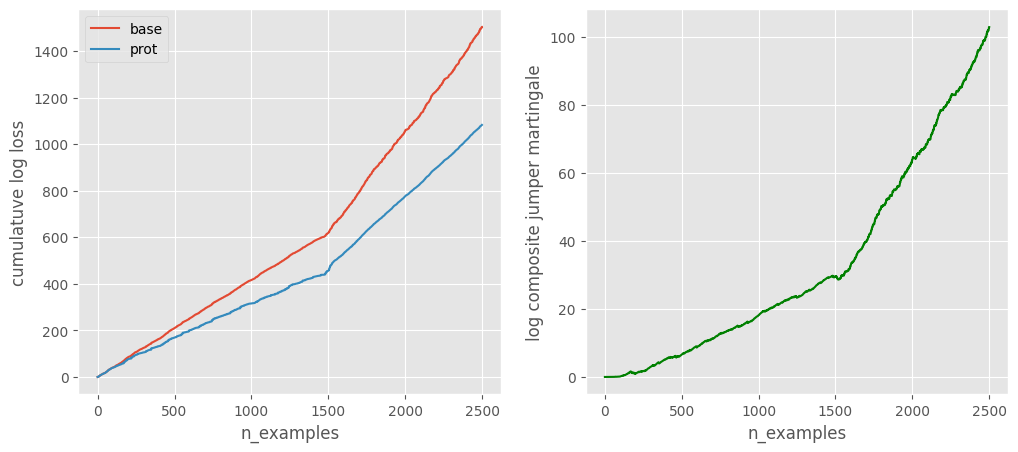

In [10]:
log_loss_err ={}
log_loss_err['base'] = np.array([-np.log(p_pred[i, y_test_shift[i]]) for i in range(len(y_test_shift))])
log_loss_err['prot'] = np.array([-np.log(p_prime[i, y_test_shift[i]]) for i in range(len(y_test_shift))])

_ , axs = plt.subplots(1, 2, figsize = (12, 5))

axs[0].plot(np.cumsum(log_loss_err['base']), label = 'base')
axs[0].plot(np.cumsum(log_loss_err['prot']), label = 'prot')
axs[0].legend()
axs[0].set_xlabel('n_examples')
axs[0].set_ylabel('cumulatuve log loss')

axs[1].plot(stats['log_cj_martingale'], color='green')
axs[1].set_xlabel('n_examples')
axs[1].set_ylabel('log composite jumper martingale')
plt.show()

The protected classifcation algorithm experiences a lower log loss, before the dataset shift due to the correction of the miscalibration of the underlying RF algorithm and post dataset shift due to the protection against it.

We consider the calibration and relative ROC scores for classes 0 and 1 only

In [11]:
ind = (y_test_shift == 0) | (y_test_shift == 1)

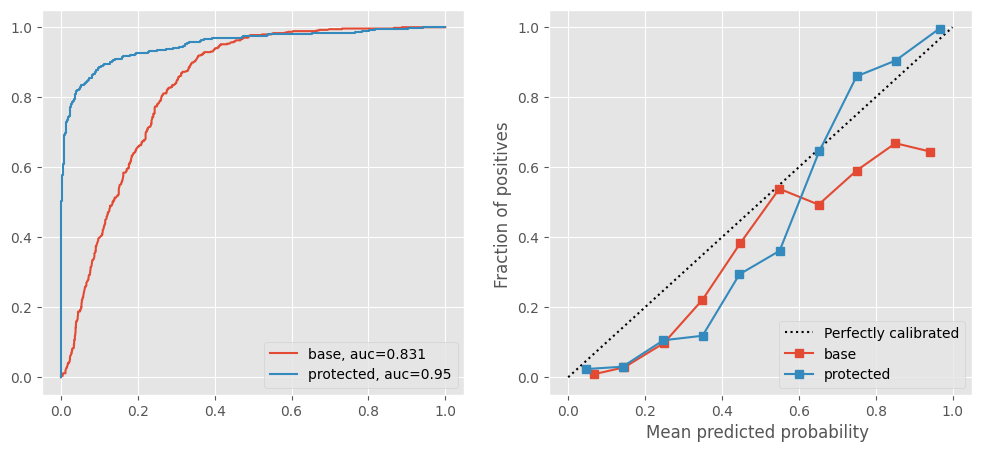

In [12]:
_ , axs = plt.subplots(1, 2, figsize = (12, 5))

fpr_pred, tpr_pred, thresh_pred = metrics.roc_curve(y_test_shift[ind], p_pred[ind,1], pos_label=1)
auc_pred = metrics.roc_auc_score(y_test_shift[ind], p_pred[ind,1])
axs[0].plot(fpr_pred,tpr_pred,label="base, auc="+str(np.around(auc_pred,decimals=3)))

fpr_prime, tpr_prime, thresh_prime = metrics.roc_curve(y_test_shift[ind], p_prime[ind,1], pos_label=1)
auc_prime = metrics.roc_auc_score(y_test_shift[ind], p_prime[ind,1])
axs[0].plot(fpr_prime,tpr_prime,label="protected, auc="+str(np.around(auc_prime,decimals=3)))
axs[0].legend()

prob_true, prob_pred = calibration_curve(y_test_shift[ind], p_pred[ind,1], n_bins=10)
cal_display_pred = CalibrationDisplay(prob_true, prob_pred, y_test_shift[ind])
cal_display_pred.plot(ax = axs[1], name='base')
prob_true, prob_pred = calibration_curve(y_test_shift[ind], p_prime[ind,1], n_bins=10)
cal_display_prime = CalibrationDisplay(prob_true, prob_pred, y_test_shift[ind])
cal_display_prime.plot(ax = axs[1], name='protected')
plt.show()

The protected classifcation algorithm delivers a better calibration and better ROAC/AUC score.

Overall the algorithm delivers higher accuracy and lower log loss for the overall test set 

In [13]:
score = log_loss(y_test_shift, p_pred)
cal_score = log_loss(y_test_shift, p_prime)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

print('')
score = accuracy_score(y_test_shift, y_pred)
cal_score = accuracy_score(y_test_shift, y_prime)

print("Accuracy of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 0.602
 * calibrated classifier: 0.433

Accuracy of
 * uncalibrated classifier: 0.797
 * calibrated classifier: 0.859
